In [27]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.utils.statistics import plot_acf, check_seasonality, plot_hist, plot_residuals_analysis
from darts.metrics import mape
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../../data/prepared/df_energy_climate_2020.csv')

In [6]:
df = df.drop(['date', 'day_of_week', 'time', 'month'], axis=1)

In [9]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 
                                   time_col="datetime",
                                   value_cols=["energy_price"])

splitting_point = (int(len(series)*0.20))

# Set aside the second half of series as a validation series
train, val = series[:-splitting_point], series[-splitting_point:]
# train, val = series.split_before(0.75)

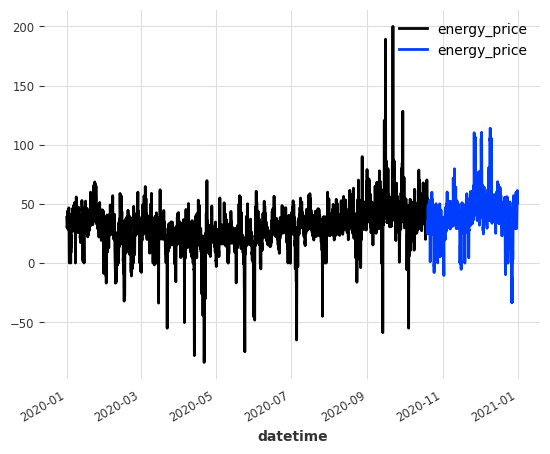

In [10]:
train.plot()
val.plot()

### Taking seasonality into account

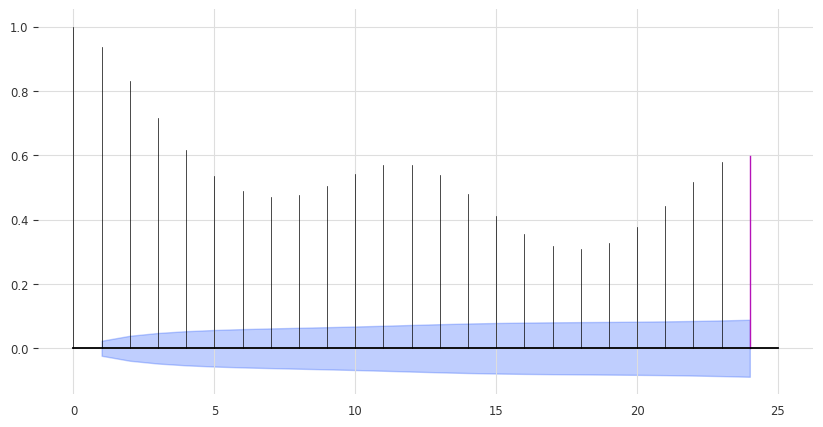

In [20]:
plot_acf(train, m=24, alpha=0.05)
# alpha = confidence level

In [21]:
# run statistical check of seasonality for each candidate period m
for m in range (2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print(f'There is seasonality of order {period}')

There is seasonality of order 12


In [15]:
model = ExponentialSmoothing(
    seasonal_periods=12
)

## Historical forecasts
Forecasting using historical data.

*Backtesting: General method for seeing how well a model would have done using historical data.

In [22]:
historical_fcast = model.historical_forecasts(
    series,
    start=0.8,
    forecast_horizon=168,
    stride=5,
    overlap_end=False,
    verbose=True
)

  0%|          | 0/319 [00:00<?, ?it/s]

MAPE = 678.11%


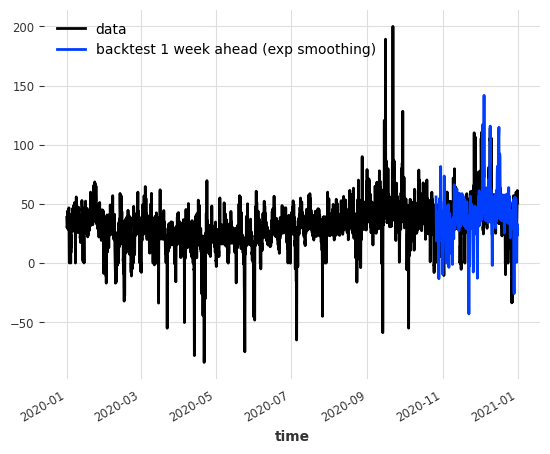

In [24]:
series.plot(label='data')
historical_fcast.plot(label='backtest 1 week ahead (exp smoothing)')
print(f'MAPE = {mape(historical_fcast, series):.2f}%')

## Backtest
It repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

In [55]:
raw_errors = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=None,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

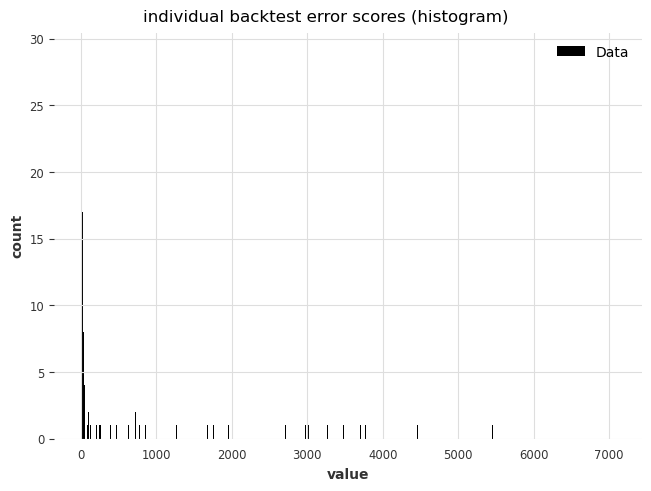

In [57]:
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title='individual backtest error scores (histogram)'
)

In [54]:
median_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=np.median,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

In [60]:
median_error

78.30537575641551

In [62]:
print(f'Median error (MAPE) over all historical forecasts: {median_error:.2f}%')

Median error (MAPE) over all historical forecasts: 78.31%


In [67]:
average_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=168,
    stride=5,
    reduction=np.mean,
    metric=mape,
    verbose=True
)

  0%|          | 0/670 [00:00<?, ?it/s]

In [68]:
print(f'Average error (MAPE) over all historical forecasts: {average_error:.2f}%')

Average error (MAPE) over all historical forecasts: 927.84%
